In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm
import random
import os, sys
import numpy as np

import DDPMUNet
from DDPMUNet import UNet
from DEMDataset import DEMDataset

In [ ]:
tile_size = 256
batch_size = 8
num_epochs = 30
dem_src_path = (
    "/Users/williameclee/geodata/projects/satellite-image-predictor/unet-input-dem.tif"
)
dataset = DEMDataset(dem_src_path, tile_size=tile_size, rotate=True, log_transform=True)


# --- 3. Training (DDPM-style) ---
def train_ddpm(
    model,
    dataset,
    batch_size=16,
    learning_rate=1e-4,
    num_epochs=20,
    subset_fraction=1.0,
    num_timesteps=100,
    save_model=True,
    device=(
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    ),
    l2loss_weight=1.0,  # (slope-weighted) L2 loss weight
    tvloss_weight=0.01,  # total variation loss weight
    slope_scale=5.0,  # slope scaling factor
):
    if subset_fraction < 1.0:
        num_epochs = round(round(num_epochs / subset_fraction))
        print(
            f"Using {subset_fraction:.0%} of the dataset, training extended to {num_epochs} epochs"
        )

    print(f"Using device: {device}")

    if isinstance(save_model, str) and os.path.exists(save_model):
        model_path = save_model
    else:
        os.makedirs("models", exist_ok=True)
        model_path = os.path.join("models", f"dem_ddpm-log{dataset.log_transform}-{dataset.tile_size}.pth")
    if save_model:
        print(f"Model will be saved to {model_path}")

    if isinstance(model, nn.Module):
        model.to(device)
    elif isinstance(model, str) and os.path.exists(model):
        model = UNet()
        model.load_state_dict(torch.load(model))
        print(f"Model loaded successfully from {model_path}")
    elif isinstance(model, str) and model == "load":
        model = UNet()
        if os.path.exists(model_path):
            print(f"Loading model from {model_path}")
            model.load_state_dict(torch.load(model_path))
        else:
            print(f"Best model not found at {model_path}, starting from scratch")
    elif isinstance(model, str) and model == "new":
        model = UNet()

    model.to(device)
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    loss_prev = np.inf

    for epoch in range(num_epochs):
        num_samples = int(len(dataset) * subset_fraction)
        indices = random.sample(range(len(dataset)), num_samples)
        sampler = SubsetRandomSampler(indices)
        dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
        model.train()
        epoch_loss = 0
        for x0 in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x0 = x0.to(device)

            if torch.isnan(x0).any():
                raise ValueError("Input tensor contains NaN values. Check your data.")

            # Sample time step
            t = torch.randint(1, num_timesteps, (x0.size(0),), device=device).long()

            # Add noise to input
            noise = torch.randn_like(x0)
            alpha = (
                1 - 0.01 * t[:, None, None, None].float() / num_timesteps
            )  # Linear schedule
            xt = alpha.sqrt() * x0 + (1 - alpha).sqrt() * noise

            # Predict the noise
            # pred_noise = model(xt, t.float() / num_timesteps)
            # loss = F.mse_loss(pred_noise, noise)

            # x0_recon = (xt - (1 - alpha).sqrt() * pred_noise) / alpha.sqrt()
            # x0_recon = x0_recon.clamp(0, 1)
            # recon_loss = F.mse_loss(x0_recon, x0)
            # # Combine losses (optional, but helps with stability)
            # loss = loss + 2 * recon_loss

            pred_noise = model(xt, t.float() / num_timesteps)
            mse_loss = F.mse_loss(pred_noise, noise)

            if torch.isnan(mse_loss):
                raise ValueError("MSE loss is NaN. Check your inputs and model.")

            # Optional: slope-weighted reconstruction loss (L_x0)
            with torch.no_grad():
                # Reconstruct x0 estimate
                alpha = 1 - 0.01 * t[:, None, None, None].float() / num_timesteps
                x0_pred = (xt - (1 - alpha).sqrt() * pred_noise) / alpha.sqrt()
                slope = DDPMUNet.compute_slope_map(x0)
                slope_weight = 1.0 + slope_scale * slope  # e.g. slope_scale = 5.0
                weighted_l2 = ((x0_pred - x0) ** 2 * slope_weight).mean()

            if torch.isnan(weighted_l2):
                raise ValueError("Weighted L2 loss is NaN. Check your inputs and model.")

            # Optional: TV regularization on x0_pred
            tv_reg = DDPMUNet.total_variation(x0_pred)

            if torch.isnan(tv_reg):
                raise ValueError("TV loss is NaN. Check your inputs and model.")

            # Final combined loss
            # loss = mse_loss + l2loss_weight * weighted_l2
            loss = mse_loss + l2loss_weight * weighted_l2 + tvloss_weight * tv_reg

            # Optimise
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            epoch_loss += loss.item()

        if loss > loss_prev * 10:
            learning_rate = learning_rate * 0.5
            print(
                f"Epoch {round((epoch+1)*subset_fraction):04d}/{round(num_epochs*subset_fraction):04d}  Loss: {loss:.3f}. Loss diverged, back tracking."
            )
            model = UNet()
            model.load_state_dict(torch.load(model_path))
            model.to(device)
        else:
            loss_prev = loss
            if save_model:
                torch.save(
                    model.state_dict(),
                    model_path,
                )
                print(
                    f"Epoch {round((epoch+1)*subset_fraction):04d}/{round(num_epochs*subset_fraction):04d}  Loss: {loss:.3f}. Model saved"
                )
            else:
                print(
                    f"Epoch {round((epoch+1)*subset_fraction):04d}/{round(num_epochs*subset_fraction):04d}  Loss: {loss:.3f}"
                )
    return model


model = train_ddpm(
    "load",
    dataset,
    batch_size=batch_size,
    num_epochs=num_epochs,
    subset_fraction=0.5e-2,
    learning_rate=1e-3,
)

Loaded 86788 DEM tiles from /Users/williameclee/geodata/projects/satellite-image-predictor/unet-input-dem-T256 with size 256x256
Using 0% of the dataset, training extended to 6000 epochs
Using device: mps
Model will be saved to models/dem_ddpm-logTrue-256.pth
Loading model from models/dem_ddpm-logTrue-256.pth


Epoch 1/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.100. Model saved


Epoch 2/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.037. Model saved


Epoch 3/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.076. Model saved


Epoch 4/6000: 100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


Epoch 0000/0030  Loss: 0.029. Model saved


Epoch 5/6000: 100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


Epoch 0000/0030  Loss: 0.079. Model saved


Epoch 6/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.063. Model saved


Epoch 7/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.042. Model saved


Epoch 8/6000: 100%|██████████| 55/55 [00:54<00:00,  1.00it/s]


Epoch 0000/0030  Loss: 0.037. Model saved


Epoch 9/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.015. Model saved


Epoch 10/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 11/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.026. Model saved


Epoch 12/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.143. Model saved


Epoch 13/6000: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s]


Epoch 0000/0030  Loss: 0.060. Model saved


Epoch 14/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.047. Model saved


Epoch 15/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.081. Model saved


Epoch 16/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.016. Model saved


Epoch 17/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.126. Model saved


Epoch 18/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.032. Model saved


Epoch 19/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.018. Model saved


Epoch 20/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.032. Model saved


Epoch 21/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.229. Model saved


Epoch 22/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.040. Model saved


Epoch 23/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.018. Model saved


Epoch 24/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.062. Model saved


Epoch 25/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.115. Model saved


Epoch 26/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.089. Model saved


Epoch 27/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 28/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.080. Model saved


Epoch 29/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.034. Model saved


Epoch 30/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.069. Model saved


Epoch 31/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 32/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.021. Model saved


Epoch 33/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.028. Model saved


Epoch 34/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 35/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.013. Model saved


Epoch 36/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.012. Model saved


Epoch 37/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.013. Model saved


Epoch 38/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.049. Model saved


Epoch 39/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.114. Model saved


Epoch 40/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.013. Model saved


Epoch 41/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.032. Model saved


Epoch 42/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.010. Model saved


Epoch 43/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.011. Model saved


Epoch 44/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.102. Model saved


Epoch 45/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.051. Model saved


Epoch 46/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.009. Model saved


Epoch 47/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.011. Model saved


Epoch 48/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 49/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.066. Model saved


Epoch 50/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.035. Model saved


Epoch 51/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.028. Model saved


Epoch 52/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.023. Model saved


Epoch 53/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.039. Model saved


Epoch 54/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 55/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.270. Loss diverged, back tracking.


Epoch 56/6000: 100%|██████████| 55/55 [00:55<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.020. Model saved


Epoch 57/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 58/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.015. Model saved


Epoch 59/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0000/0030  Loss: 0.078. Model saved


Epoch 60/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.024. Model saved


Epoch 61/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.304. Loss diverged, back tracking.


Epoch 62/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.017. Model saved


Epoch 63/6000: 100%|██████████| 55/55 [00:56<00:00,  1.02s/it]


Epoch 0000/0030  Loss: 0.056. Model saved


Epoch 64/6000: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 0000/0030  Loss: 0.040. Model saved


Epoch 65/6000: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 0000/0030  Loss: 0.017. Model saved


Epoch 66/6000: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 0000/0030  Loss: 0.055. Model saved


Epoch 67/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.075. Model saved


Epoch 68/6000: 100%|██████████| 55/55 [00:58<00:00,  1.07s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 69/6000: 100%|██████████| 55/55 [00:58<00:00,  1.07s/it]


Epoch 0000/0030  Loss: 0.044. Model saved


Epoch 70/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.142. Model saved


Epoch 71/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 72/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.092. Model saved


Epoch 73/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 74/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.028. Model saved


Epoch 75/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.020. Model saved


Epoch 76/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.021. Model saved


Epoch 77/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.033. Model saved


Epoch 78/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.031. Model saved


Epoch 79/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.046. Model saved


Epoch 80/6000: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 0000/0030  Loss: 0.023. Model saved


Epoch 81/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.133. Model saved


Epoch 82/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.110. Model saved


Epoch 83/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.019. Model saved


Epoch 84/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.018. Model saved


Epoch 85/6000: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]


Epoch 0000/0030  Loss: 0.015. Model saved


Epoch 86/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.036. Model saved


Epoch 87/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.040. Model saved


Epoch 88/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.016. Model saved


Epoch 89/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.057. Model saved


Epoch 90/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0000/0030  Loss: 0.045. Model saved


Epoch 91/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.137. Model saved


Epoch 92/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.050. Model saved


Epoch 93/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.064. Model saved


Epoch 94/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.022. Model saved


Epoch 95/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.082. Model saved


Epoch 96/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.028. Model saved


Epoch 97/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.014. Model saved


Epoch 98/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.016. Model saved


Epoch 99/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0000/0030  Loss: 0.117. Model saved


Epoch 100/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0000/0030  Loss: 0.411. Model saved


Epoch 101/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.045. Model saved


Epoch 102/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0001/0030  Loss: 0.054. Model saved


Epoch 103/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.046. Model saved


Epoch 104/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.026. Model saved


Epoch 105/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.028. Model saved


Epoch 106/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.039. Model saved


Epoch 107/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0001/0030  Loss: 0.067. Model saved


Epoch 108/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.021. Model saved


Epoch 109/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.174. Model saved


Epoch 110/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0001/0030  Loss: 0.014. Model saved


Epoch 111/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.065. Model saved


Epoch 112/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.030. Model saved


Epoch 113/6000: 100%|██████████| 55/55 [00:56<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.023. Model saved


Epoch 114/6000: 100%|██████████| 55/55 [00:56<00:00,  1.03s/it]


Epoch 0001/0030  Loss: 0.025. Model saved


Epoch 115/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.031. Model saved


Epoch 116/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.020. Model saved


Epoch 117/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.039. Model saved


Epoch 118/6000: 100%|██████████| 55/55 [00:57<00:00,  1.04s/it]


Epoch 0001/0030  Loss: 0.134. Model saved


Epoch 119/6000: 100%|██████████| 55/55 [00:57<00:00,  1.05s/it]


Epoch 0001/0030  Loss: 0.018. Model saved


Epoch 120/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0001/0030  Loss: 0.041. Model saved


Epoch 121/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0001/0030  Loss: 0.081. Model saved


Epoch 122/6000: 100%|██████████| 55/55 [01:00<00:00,  1.09s/it]


Epoch 0001/0030  Loss: 0.047. Model saved


Epoch 123/6000: 100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 0001/0030  Loss: 0.114. Model saved


Epoch 124/6000: 100%|██████████| 55/55 [00:59<00:00,  1.09s/it]


Epoch 0001/0030  Loss: 0.052. Model saved


Epoch 125/6000: 100%|██████████| 55/55 [00:59<00:00,  1.09s/it]


Epoch 0001/0030  Loss: 0.015. Model saved


Epoch 126/6000: 100%|██████████| 55/55 [00:59<00:00,  1.09s/it]


Epoch 0001/0030  Loss: 0.026. Model saved


Epoch 127/6000: 100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 0001/0030  Loss: 0.014. Model saved


Epoch 128/6000: 100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 0001/0030  Loss: 0.014. Model saved


Epoch 129/6000: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]


Epoch 0001/0030  Loss: 0.017. Model saved


Epoch 130/6000: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]


Epoch 0001/0030  Loss: 0.042. Model saved


Epoch 131/6000: 100%|██████████| 55/55 [01:00<00:00,  1.10s/it]


Epoch 0001/0030  Loss: 0.023. Model saved


Epoch 132/6000: 100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 0001/0030  Loss: 0.015. Model saved


Epoch 133/6000: 100%|██████████| 55/55 [01:01<00:00,  1.11s/it]


Epoch 0001/0030  Loss: 0.046. Model saved


Epoch 134/6000: 100%|██████████| 55/55 [00:58<00:00,  1.06s/it]


Epoch 0001/0030  Loss: 0.157. Model saved


Epoch 135/6000: 100%|██████████| 55/55 [00:59<00:00,  1.08s/it]


Epoch 0001/0030  Loss: 0.031. Model saved


Epoch 136/6000: 100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


Epoch 0001/0030  Loss: 0.025. Model saved


Epoch 137/6000: 100%|██████████| 55/55 [01:03<00:00,  1.16s/it]


Epoch 0001/0030  Loss: 0.015. Model saved


Epoch 138/6000: 100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


Epoch 0001/0030  Loss: 0.420. Loss diverged, back tracking.


Epoch 139/6000: 100%|██████████| 55/55 [01:03<00:00,  1.15s/it]


Epoch 0001/0030  Loss: 0.020. Model saved


Epoch 140/6000:  35%|███▍      | 19/55 [00:22<00:43,  1.21s/it]


KeyboardInterrupt: 

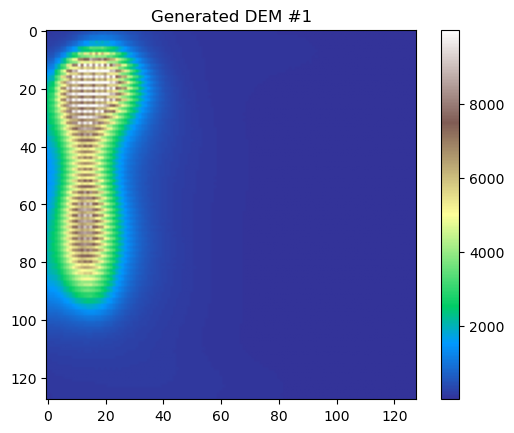

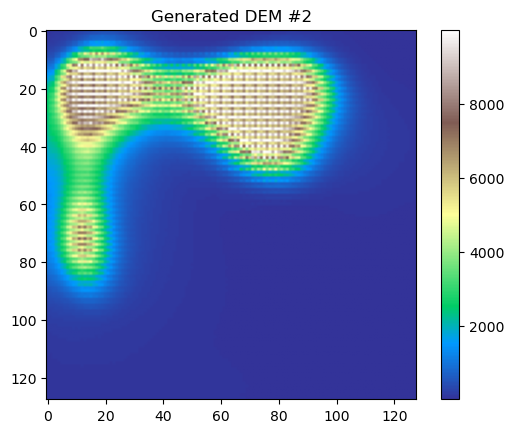

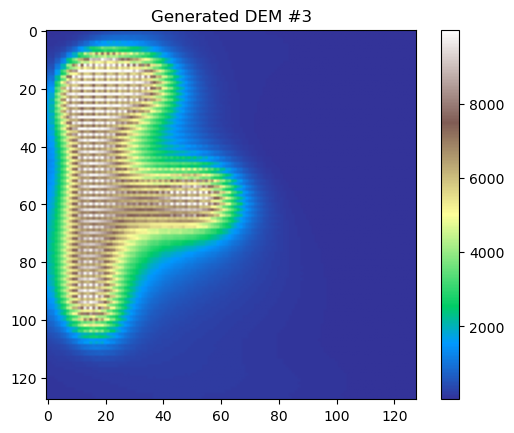

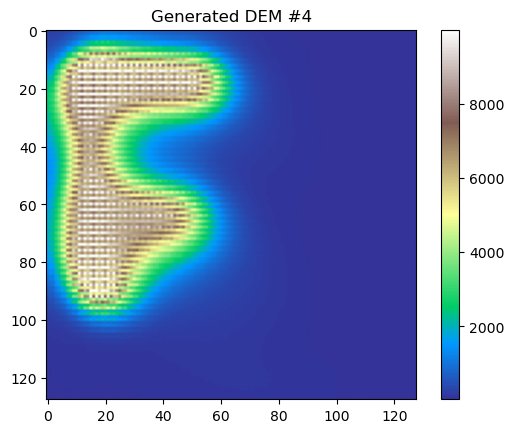

In [17]:
import matplotlib.pyplot as plt

model = UNet()
model.to("mps")
model.load_state_dict(torch.load(f"models/dem_ddpm-logTrue-{tile_size}.pth"))


# --- 4. Visualisation (Denoising one sample) ---
def denoise_sample(model, shape, steps=100, device="mps"):
    model.eval()
    x = torch.randn(shape, device=device)
    with torch.no_grad():
        for i in reversed(range(1, steps + 1)):
            t = torch.full((shape[0],), i / steps, device=device)
            noise_pred = model(x, t)
            alpha = 1 - 0.01 * t[:, None, None, None]
            x = (x - (1 - alpha).sqrt() * noise_pred) / alpha.sqrt()
            x = x.clamp(min=0.0, max=1.0)
    return x.cpu()


samples = denoise_sample(model, (4, 1, 128, 128))
for i in range(4):
    dem = samples[i][0].numpy()
    # undo base-10 log transform
    dem = 10 ** (dem * 4) - 1
    plt.imshow(dem, cmap="terrain")
    plt.colorbar()
    plt.title(f"Generated DEM #{i+1}")
    plt.show()

Loaded 86788 DEM tiles from /Users/williameclee/geodata/projects/satellite-image-predictor/unet-input-dem-T256 with size 256x256


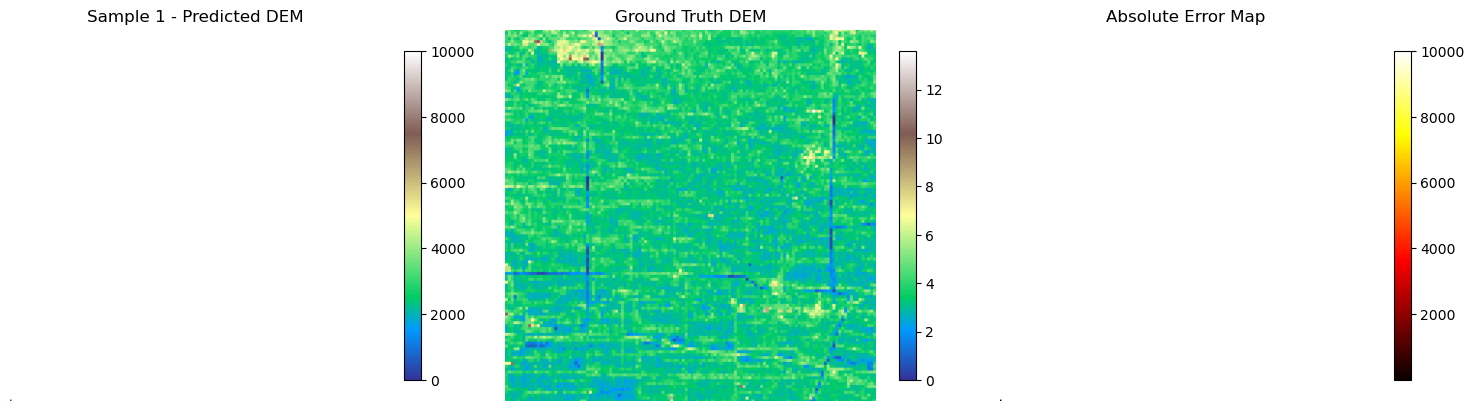

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
from torchvision import transforms
from tqdm import tqdm
import rasterio
from rasterio.windows import Window
import random

sys.path.append("models")
from DDPMUNet import UNet
from DEMDataset import DEMDataset


def plot_dem_comparison(
    pred, real=None, normalisation_factor=1, index=0, title_prefix=""
):
    """
    Visualize predicted DEM and optionally compare with real DEM.

    Args:
        pred: [B, 1, H, W] torch tensor (generated DEMs)
        real: [B, 1, H, W] torch tensor (ground truth DEMs), optional
        index: which sample in the batch to visualize
        title_prefix: e.g. "Epoch 10 -"
    """
    pred_np = pred[index, 0].detach().cpu().numpy()
    pred_np = pred_np * normalisation_factor  # Rescale back to original scale if needed

    fig, axes = plt.subplots(1, 3 if real is not None else 1, figsize=(15, 5))
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]

    axes[0].imshow(pred_np, cmap="terrain")
    axes[0].set_title(f"{title_prefix} Predicted DEM")
    axes[0].axis("off")
    plt.colorbar(axes[0].imshow(pred_np, cmap="terrain"), ax=axes[0], shrink=0.7)

    if real is not None:
        real_np = real[index, 0].detach().cpu().numpy()
        real_np = (
            real_np * normalisation_factor
        )  # Rescale back to original scale if needed
        diff = abs(pred_np - real_np)

        axes[1].imshow(real_np, cmap="terrain")
        axes[1].set_title("Ground Truth DEM")
        axes[1].axis("off")
        plt.colorbar(axes[1].imshow(real_np, cmap="terrain"), ax=axes[1], shrink=0.7)

        axes[2].imshow(diff, cmap="hot")
        axes[2].set_title("Absolute Error Map")
        axes[2].axis("off")
        plt.colorbar(axes[2].imshow(diff, cmap="hot"), ax=axes[2], shrink=0.7)

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def denoise_sample(model, shape, steps=50, device="mps"):
    model.eval()
    x = torch.randn(shape, device=device)
    for i in reversed(range(1, steps + 1)):
        t = torch.full((shape[0],), i / steps, device=device)
        noise_pred = model(x, t)
        alpha = 1 - 0.01 * t[:, None, None, None]
        x = (x - (1 - alpha).sqrt() * noise_pred) / alpha.sqrt()
    return x.clamp(0, 1)


tile_size = 256

dem_src_path = (
    "/Users/williameclee/geodata/projects/satellite-image-predictor/unet-input-dem.tif"
)
dataset = DEMDataset(dem_src_path, tile_size=tile_size, rotate=True)
loader = DataLoader(dataset, batch_size=4, shuffle=True)
x0 = next(iter(loader)).to("mps")

model = UNet()
model.to("mps")
model.load_state_dict(torch.load(f"models/dem_ddpm-{tile_size}.pth"))

# Generate predicted DEMs
x_gen = denoise_sample(model, shape=x0.shape, device="mps")


# x0 is your real DEM batch (optional)
# x_gen is your predicted/generated DEM batch
plot_dem_comparison(x_gen, real=x0, normalisation_factor=dataset.normalise_factor, index=0, title_prefix="Sample 1 -")